# Lab 2: Regularized Least Square
In this lab, we focus on RLS to address linear regression problems.

In this lab, we have to:
- **(Task 1)** implement RLS to solve linear regression problems
- **(Task 2)** observe performance of RLS changing the noise in the data and the regularization parameter
- **(Task 3)** implement K-Fold Cross-Validation algorithm for RLS


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

## Data generation
To generate linear regression data, we use the `linearRegrFunction` introduced in Lab0.

In [2]:
def linearRegrFunction(n, D, low_D, high_D, W, sigma_noise):
    X = np.zeros((n,D))
    for i in range(0, D):
        X[:,i] = np.random.uniform(low_D[i], high_D[i], size=n)

    gauss_noise = np.random.normal(0, sigma_noise, size=(n,1))

    Y = np.dot(X, W) + gauss_noise

    return X, Y

### Example: Noiseless dataset


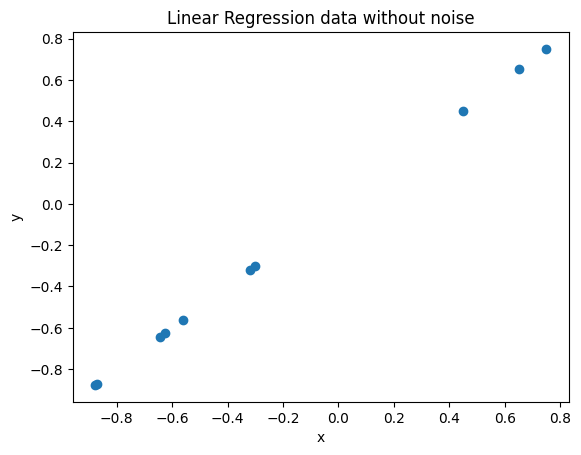

In [3]:
n = 10
D = 1
low_D, high_D = [-1], [1]
w = np.array(1.0).reshape(1, 1)
noise_std = 0.0

# Data generation
X, Y = linearRegrFunction(n, D, low_D, high_D, w, noise_std)

# Plot of the data
_, ax = plt.subplots()
ax.set_title("Linear Regression data without noise")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(X, Y)

## Task 1: RLS regressor
We want to implement the `regularizedLSTrain` function which train RLS regression.

The signature of `regularizedLSTrain` is the following:

`w = regularizedLSTrain(Xtr, Ytr, lam)`

where:
- **Xtr** are the training inputs
- **Ytr** are the training outputs
- **lam** is the regularization parameter $\lambda$

To implement this function, you will need to use the following functions from numpy:

- [`np.linalg.cholesky`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html)
- [`scipy.linalg.solve_triangular`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html)

Consider

**$(X_{tr}^\intercal X_{tr} + \lambda n I)w = X_{tr}^\intercal Y_{tr}$**

Let $A = X_{tr}^\intercal X_{tr} + \lambda n I$ and $b = X_{tr}^\intercal Y_{tr}$, we can find $w$ with the following steps:
1. First build the left-hand side matrix `A`, and the right-hand side matrix `b`.
2. Compute the Cholesky decomposition of `A` (note that the numpy function will provide a lower-triangular matrix)
3. You will have to solve two triangular systems, one using the Cholesky decomposition, and the other using its transpose.

In [4]:
def regularizedLSTrain(Xtr, Ytr, lam):
    # Insert your code here

    # Get the number of training examples and the number of features
    n, m = Xtr.shape

    # Build the left-hand side matrix A (A = X^T * X + λ * n * I)
    # @ Is the matrix multiplication in NumPy
    # np.eye(X.shape[m]) creates an identity matrix of the appropriate dimension.
    A = (Xtr.T @ Xtr) + (lam * n * np.eye(m))

    # Compute the matrix b = X⊺tr Ytr
    b = (Xtr.T @ Ytr)

    # Compute the Cholesky decomposition of A
    L = np.linalg.cholesky(A)

    # Solve for w using forward substitution (Lw = b)
    #w = np.linalg.solve(L, b)
    w = scipy.linalg.solve_triangular(L,b,lower=True)

    # Solve for w using back substitution (L^T * w = w)
    #w = np.linalg.solve(L.T, w)
    w = scipy.linalg.solve_triangular(L.T, w)

    return w

We need also to implement a function `regularizedLSTest` which given a test set `Xte` and the `w` obtained using `regularizedLSTrain`, it returns `Ypred` containing the predictions

In [5]:
def regularizedLSTest(w, Xte):
    # Insert your code here

    # Compute predictions Ypred using the learned coefficients w
    Ypred = Xte @ w

    return Ypred

To evaluate the performance of RLS regressor, we need a function to estimate the error.

Given two vectors `Ytrue` (real outputs) and `Ypred` (predicted outputs), we can measure the error obtained when predicting `Ypred` instead of `Ytrue` with the MSE (Mean Square Error)

In [6]:
def calcError(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

Now we can build an easy example to observe how our model works:
- Generate a training set with **ntrain** points and a test set with **ntest** points
- Train RLS with `regularizedLSTrain` function and test it with `regularizedLSTest` on test set
- Compute the training and test error

In [7]:
ntrain = 100
ntest = 50
D = 1
low_D = [-1] * D
high_D = [5] * D
rnd_state = np.random.RandomState(42)
wtrue = rnd_state.randn(D, 1)
noise_std = 0.1

lam = 1e-3

# Generate a training set with ntrain points and a test set with ntest
Xtr, Ytr = linearRegrFunction(ntrain, D, low_D, high_D, wtrue, noise_std)
Xte, Yte = linearRegrFunction(ntest, D, low_D, high_D, wtrue, noise_std)

# Train RLS
w = regularizedLSTrain(Xtr, Ytr, lam)

# Compute predictions on training and test set
Ytr_pred = regularizedLSTest(w,Xtr)
Yte_pred = regularizedLSTest(w,Xte)

train_err = calcError(Ytr_pred, Ytr)
test_err = calcError(Yte_pred, Yte)

print("[--] Training error: {}\tTest error: {}".format(train_err, test_err))

[--] Training error: 0.008955525351688589	Test error: 0.006339119410050167


## Task 2: Changing $\lambda$
Now we can play with our model changing the noise level in the data and changing the $\lambda$ parameter.

Let's start by changing $\lambda$ and fixing the other parameters.

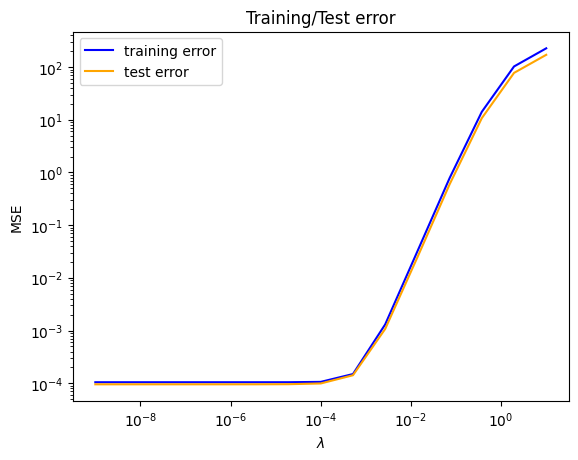

In [8]:
ntrain = 500
ntest = 100
D = 2
low_D = [-2] * D
high_D = [2] * D
w_true = np.array([i for i in range(D)]).reshape(D, 1) + 10
noise_std = 0.01


# Data generation
Xtr, Ytr = linearRegrFunction(ntrain, D, low_D, high_D, w_true, noise_std)
Xte, Yte = linearRegrFunction(ntest, D, low_D, high_D, w_true, noise_std)

lam_list = np.logspace(-9, 1, 15)
tr_err = []
te_err = []

# "Base" Noise level
for lam in lam_list:

    # Train RLS
    w = regularizedLSTrain(Xtr, Ytr, lam)

    # Compute predictions on training and test set
    Ytr_pred = regularizedLSTest(w,Xtr)
    Yte_pred = regularizedLSTest(w,Xte)

    # Compute training and test error and store them on tr_err and te_err
    tr_err.append(calcError(Ytr_pred, Ytr))
    te_err.append(calcError(Yte_pred, Yte))


# Plot training and test error
_, ax = plt.subplots()
ax.set_title("Training/Test error")
ax.plot(lam_list, tr_err, '-', c="blue", label="training error")
ax.plot(lam_list, te_err, '-', c="orange", label="test error")
ax.legend(loc="best")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.set_xscale("log")
ax.set_yscale("log")


**Explain here what happens when $\lambda$ increases:**

The regularization parameter $\lambda$ plays a crucial role in controlling the trade-off between fitting and training data and preventing overfitting. When $\lambda$ is increased the following occurs:

1. **Increased regularization**: the model's coefficients are penalized more strongly, which encourage them to be smaller and closer to zero;
2. Makes the model **less sensitive to outliers** in the training data. Since the model's coefficients are constrained to be small, extreme values in the trainig data have a smaller impact on the model's predicitions;
3. The model tends to generalize better to new, unssen data. It becomes more robust, which lead to better performance on a validation or test dataset;
4. Last but not least, increasing $\lambda$ decreases the model's variance but increase its bias. In other words, the model becomes more biased toward a simpler structure and may underfit the trainig data if the $\lambda$ value is too high.

So, finding the right value of $\lambda$ is essential to achieve good model performance and one way to do so is to perform cross-validation with various value of $\lambda$ to find the one that results in the best model performance on validation data.



**Now, increase the amount of noise and repeat the experiment. What do you observe?**

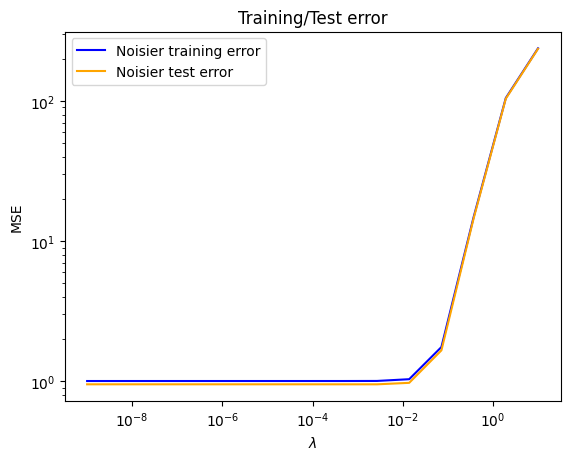

In [9]:
ntrain = 500
ntest = 100
D = 2
low_D = [-2] * D
high_D = [2] * D
w_true = np.array([i for i in range(D)]).reshape(D, 1) + 10
noise_std = 1


# Data generation
Xtr, Ytr = linearRegrFunction(ntrain, D, low_D, high_D, w_true, noise_std)
Xte, Yte = linearRegrFunction(ntest, D, low_D, high_D, w_true, noise_std)

lam_list = np.logspace(-9, 1, 15)
tr_err = []
te_err = []

# "Base" Noise level
for lam in lam_list:

    # Train RLS
    w = regularizedLSTrain(Xtr, Ytr, lam)

    # Compute predictions on training and test set
    Ytr_pred = regularizedLSTest(w,Xtr)
    Yte_pred = regularizedLSTest(w,Xte)

    # Compute training and test error and store them on tr_err and te_err
    tr_err.append(calcError(Ytr_pred, Ytr))
    te_err.append(calcError(Yte_pred, Yte))


# Plot training and test error
_, ax = plt.subplots()
ax.set_title("Training/Test error")
ax.plot(lam_list, tr_err, '-', c="blue", label="Noisier training error")
ax.plot(lam_list, te_err, '-', c="orange", label="Noisier test error")
ax.legend(loc="best")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.set_xscale("log")
ax.set_yscale("log")


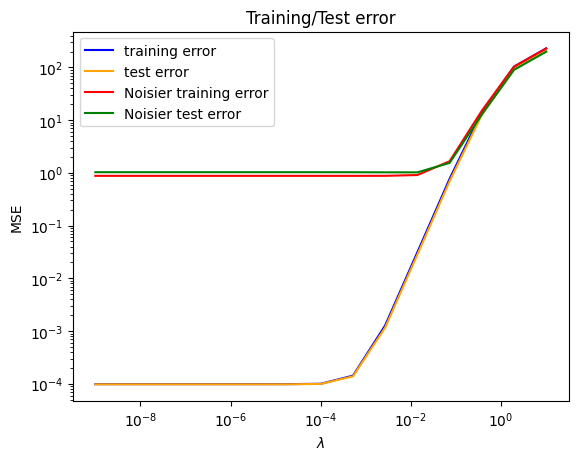

In [10]:
ntrain = 500
ntest = 100
D = 2
low_D = [-2] * D
high_D = [2] * D
w_true = np.array([i for i in range(D)]).reshape(D, 1) + 10
noise_std = 0.01
noise_std_2 = 1

# Data generation
Xtr, Ytr = linearRegrFunction(ntrain, D, low_D, high_D, w_true, noise_std)
Xte, Yte = linearRegrFunction(ntest, D, low_D, high_D, w_true, noise_std)

Xtr_noise, Ytr_noise = linearRegrFunction(ntrain, D, low_D, high_D, w_true, noise_std_2)
Xte_noise, Yte_noise = linearRegrFunction(ntest, D, low_D, high_D, w_true, noise_std_2)


lam_list = np.logspace(-9, 1, 15)
tr_err = []
te_err = []
tr_err_noise = []
te_err_noise = []


for lam in lam_list:

    # --------------------------------["Base" Noise level]--------------------------------
    # Train RLS
    w = regularizedLSTrain(Xtr, Ytr, lam)

    # Compute predictions on training and test set
    Ytr_pred = regularizedLSTest(w,Xtr)
    Yte_pred = regularizedLSTest(w,Xte)

    # Compute training and test error and store them on tr_err and te_err
    tr_err.append(calcError(Ytr_pred, Ytr))
    te_err.append(calcError(Yte_pred, Yte))

    # --------------------------------[Higher Noise level]--------------------------------
    # Train RLS
    w = regularizedLSTrain(Xtr_noise, Ytr_noise, lam)

    # Compute predictions on training and test set
    Ytr_pred = regularizedLSTest(w,Xtr_noise)
    Yte_pred = regularizedLSTest(w,Xte_noise)

    # Compute training and test error and store them on tr_err and te_err
    tr_err_noise.append(calcError(Ytr_pred, Ytr_noise))
    te_err_noise.append(calcError(Yte_pred, Yte_noise))


# Plot training and test error
_, ax = plt.subplots()
ax.set_title("Training/Test error")
ax.plot(lam_list, tr_err, '-', c="blue", label="training error")
ax.plot(lam_list, te_err, '-', c="orange", label="test error")
ax.plot(lam_list, tr_err_noise, '-', c="red", label="Noisier training error")
ax.plot(lam_list, te_err_noise, '-', c="green", label="Noisier test error")
ax.legend(loc="best")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.set_xscale("log")
ax.set_yscale("log")

Increasing the noise in a RLS regression tends to degrade the model's performance, increase the prediticion error and result in a higher MSE (Mean Squared Error).
In the graph we can see how this is true for "low" values of lambda but how at high values this is very much equivalent to the version with less noise.

## Task 3: K-Fold Cross Validation for RLS
Now, we want to implement the K-Fold Cross Validation for RLS.

In specific we want to implement the `KFoldCVRLS` function which, given a training set **Xtr** and **Ytr**, a number of folds **KF** and a set of values for $\lambda$ (**regpar_list**) and returns the $\lambda$ which minimize the average validation error **bestlam**, the mean validation error **val_mean**, the validation error variance **val_var**, the mean training error **tr_mean** and the training error variance **tr_var**.

`bestlam, val_mean, val_var, tr_mean, tr_var = KFoldCVRLS(Xtr, Ytr, KF, regpar_list)`

**Hint:** this function is very similar to K-Fold Cross-Validation algorithm for KNN (Lab1)

In [11]:
def KFoldCVRLS(Xtr, Ytr, KF, regpar_list):
    if KF <= 1:
        raise Exception("Please supply a number of fold > 1")

    # Ensures that regpar_list is a numpy array
    regpar_list = np.array(regpar_list)
    num_regpar = regpar_list.size

    n_tot = Xtr.shape[0]
    n_val = int(n_tot // KF)

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_regpar, KF))
    val_errors = np.zeros((num_regpar, KF))

    for idx, regpar in enumerate(regpar_list):
        # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
        rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
        split_idx = np.array_split(rand_idx, KF)
        for fold in range(KF):
            # Set the indices in boolean mask for all validation samples to `True`
            val_mask = np.zeros(n_tot, dtype=bool)
            val_mask[split_idx[fold]] = True

            # Use the boolean mask to split X, Y in training and validation part
            X = Xtr[~val_mask] # training input
            Y = Ytr[~val_mask] # training output
            X_val = Xtr[val_mask] # validation input
            Y_val = Ytr[val_mask] # validation output

            # Train a RLS model for a single fold, and the given value of `regpar`
            currW = regularizedLSTrain(X, Y, regpar)

            # Compute the training error of the RLS regression for the given value of regpar
            YpredTR = regularizedLSTest(currW, X)
            tr_errors[idx, fold] = calcError(YpredTR, Y)

            # Compute the validation error of the RLS regression for the given value of regpar
            YpredVAL = regularizedLSTest(currW, X_val)
            val_errors[idx, fold] = calcError(YpredVAL, Y_val)

    # Calculate error statistics along the repetitions
    tr_mean = np.mean(tr_errors, axis=1)
    tr_var = np.var(tr_errors, axis=1)
    val_mean = np.mean(val_errors, axis=1)
    val_var = np.var(val_errors, axis=1)

    bestlam_idx = np.argmin(val_mean)
    bestlam = regpar_list[bestlam_idx]

    return bestlam, val_mean, val_var, tr_mean, tr_var

Use `KFoldCVRLS` to find the best regularization parameter

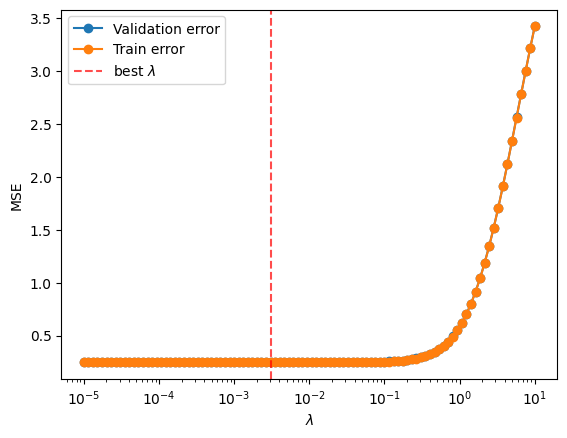

In [12]:
n = 1000
D = 1
sigma_noise = 0.5
truew = np.random.randn(D, 1)
reg_pars = np.logspace(-5, 1, 100)
KF = 5

low_D = [-3] * D
high_D = [3] * D

# Generate training set
Xtr, Ytr =  linearRegrFunction(n, D, low_D, high_D, truew, sigma_noise)

# Compute best lambda
bestlam, Vm, Vs, Tm, Ts = KFoldCVRLS(Xtr, Ytr, KF, reg_pars)


# Plot training and validation error
_, ax = plt.subplots()
ax.plot(reg_pars, Vm, '-o', label="Validation error")
ax.plot(reg_pars, Tm, '-o', label="Train error")
ax.axvline(bestlam, linestyle="--", c="red", alpha=0.7, label="best $\lambda$")
ax.set_xscale("log")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.legend(loc="best")

Use the best $\lambda$ found to train the model on the full training set and compute the test error on the following test set.   

In [13]:
Xte, Yte = linearRegrFunction(200, D, low_D, high_D, truew, sigma_noise)

print("[--] best lambda found: {}".format(bestlam))

# Insert your code here
w_best = regularizedLSTrain(Xte, Yte, bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)
test_err = calcError(Ypred_best, Yte)

print("[--] Test error: {}".format(test_err))

[--] best lambda found: 0.0030538555088334154
[--] Test error: 0.277670349381516


What changes if you repeat the latter step with a value of Lambda which is not the optimal?

In [14]:
min_value = 0.01
max_value = 0.1
random_lam = bestlam + np.random.uniform(min_value, max_value)

print(f"[--------------------RANDOM LAMBDA: {random_lam}-------------------------]")
print("[--] Best lambda found: {}".format(bestlam))
print("[--] Random lambda found: {}".format(random_lam))

# Insert your code here
w_best = regularizedLSTrain(Xte, Yte, random_lam)
Ypred_best = regularizedLSTest(w_best, Xte)
test_err = calcError(Ypred_best, Yte)

print("[--] Test error: {}".format(test_err))



min_value = 10
max_value = 30
random_lam = bestlam + np.random.uniform(min_value, max_value)

print(f"[--------------------RANDOM LAMBDA: {random_lam}-------------------------]")
print("[--] Best lambda found: {}".format(bestlam))
print("[--] Random lambda found: {}".format(random_lam))

# Insert your code here
w_best = regularizedLSTrain(Xte, Yte, random_lam)
Ypred_best = regularizedLSTest(w_best, Xte)
test_err = calcError(Ypred_best, Yte)

print("[--] Test error: {}".format(test_err))

[--------------------RANDOM LAMBDA: 0.07772544002755147-------------------------]
[--] Best lambda found: 0.0030538555088334154
[--] Random lambda found: 0.07772544002755147
[--] Test error: 0.2809289556400318
[--------------------RANDOM LAMBDA: 19.558613897764932-------------------------]
[--] Best lambda found: 0.0030538555088334154
[--] Random lambda found: 19.558613897764932
[--] Test error: 4.076774311704938


If we choose the value of the new lambda in the following way, `best lambda + random value between [0.01, 0.1]` the test error value does not change too much from the previously calculated one but this obviously depends on the fact that the value of the random lambda does not deviate much from the best.
In case we tried to add a much more higher value the situation would change dramatically since we could generate case histories in which the value of the error is almost twice as large as the best case

### To go deeper

Create new training **and** test datasets, sampled in a non-symmetric range (for example you can set the `low_D` and `high_D` parameters of the `linearRegrFunction` function to 2 and 5).

Then repeat the K-fold CV procedure, and check whether the best regularization parameter changes!

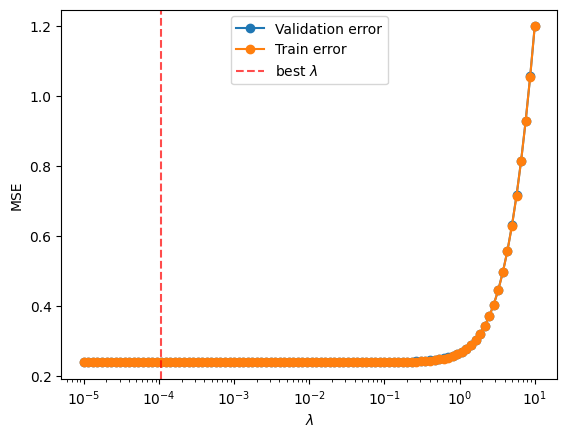

In [15]:
# Insert your code here
n = 1000
D = 1
sigma_noise = 0.5
truew = np.random.randn(D, 1)
reg_pars = np.logspace(-5, 1, 100)
KF = 5

low_D = [2] * D
high_D = [5] * D

# Generate training set
Xtr, Ytr =  linearRegrFunction(n, D, low_D, high_D, truew, sigma_noise)

# Compute best lambda
bestlam, Vm, Vs, Tm, Ts = KFoldCVRLS(Xtr, Ytr, KF, reg_pars)


# Plot training and validation error
_, ax = plt.subplots()
ax.plot(reg_pars, Vm, '-o', label="Validation error")
ax.plot(reg_pars, Tm, '-o', label="Train error")
ax.axvline(bestlam, linestyle="--", c="red", alpha=0.7, label="best $\lambda$")
ax.set_xscale("log")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.legend(loc="best")

In [16]:
Xte, Yte = linearRegrFunction(200, D, low_D, high_D, truew, sigma_noise)

print("[--] best lambda found: {}".format(bestlam))

# Insert your code here
w_best = regularizedLSTrain(Xte, Yte, bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)
test_err = calcError(Ypred_best, Yte)

print("[--] Test error: {}".format(test_err))

[--] best lambda found: 0.00010722672220103231
[--] Test error: 0.237935435988003
